# Uncertainties
Uncertainties in the MinKit package are computed using the Hessian matrix. A more accurate uncertainty can be obtained by minimizing a PDF for several fixed values of a parameter(s). In Minuit, this is done using MINOS. However, MinKit provides a dedicated function to evaluate asymmetric uncertainties. The result is identical to that of MINOS, as can be see in the following example:

FCN = 1147.6748660705514 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 1.2715332483211958e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,20.3789,0.405125,,,15,25,No
1,s,5.01931,0.394047,,,3,10,No


Error,-0.3596714446492078,0.43965226997782686
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Value (profile): 5.0193 + 0.4397 - 0.3597
Value (minkit):  5.0193 + 0.4397 - 0.3597
Value (minos):   5.0193 + 0.4397 - 0.3597


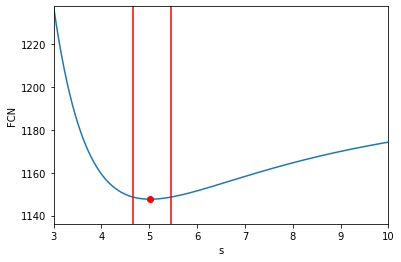

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import minkit
import numpy as np

from scipy.interpolate import make_interp_spline

m = minkit.Parameter('m', bounds=(10, 30))
c = minkit.Parameter('c', 20, bounds=(15, 25))
s = minkit.Parameter('s', 5, bounds=(3, 10))
g = minkit.Gaussian('g', m, c, s)

data = g.generate(200)

# Calculate the profile and the distance to the minimum
values = np.linspace(*s.bounds, 1000)

with minkit.minimizer('uml', g, data) as minimizer:
  
    r = minimizer.minimize()
    
    minimizer.minos('s') # minos must run before so the internal state of the minimum is set
    
    smn = s.copy()
    
    minimizer.minuit.print_level = 0 # reduce the verbosity of Minuit
    profile = minimizer.minimization_profile('s', values)
    minimizer.asymmetric_errors('s')
    
    skt = s.copy()

# Split in left and right parts
distances = profile - r.fcn

cond = (values < s.value)

left_values = values[cond]
left_distances = distances[cond]
right_values = values[~cond]
right_distances = distances[~cond]

# Calculate the position where the FCN varies one unit
left_int = make_interp_spline(left_distances[::-1], left_values[::-1])
right_int = make_interp_spline(right_distances, right_values)

lv, rv = left_int(1), right_int(1)

# Plot the results
fmin, fmax = 0.99 * profile.min(), profile.max()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(values, profile);
ax.plot([s.value], [r.fcn], marker='o', color='red');
ax.plot((lv, lv), (fmin, fmax), 'r-', )
ax.plot((rv, rv), (fmin, fmax), 'r-', )
ax.set_xlabel('s');
ax.set_ylabel('FCN');
ax.set_xlim(*s.bounds)
ax.set_ylim(fmin, fmax);

# Show the result from the different methods
print(f'Value (profile): {s.value:.4f} + {rv - s.value:.4f} - {s.value - lv:.4f}')
print(f'Value (minkit):  {skt.value:.4f} + {skt.asym_errors[1]:.4f} - {skt.asym_errors[0]:.4f}')
print(f'Value (minos):   {smn.value:.4f} + {smn.asym_errors[1]:.4f} - {smn.asym_errors[0]:.4f}')